In [1]:
%pylab inline
from IPython import display
import scipy.integrate as sci
import scipy.special as spe
import scipy.optimize as opt

Populating the interactive namespace from numpy and matplotlib


In [2]:
#analytic velocity determination

# the substrate will have a different length for each potential steady state velocity
def xsf(v,t):
    dx = 0.1
    travel = abs(v*t)
    if travel < 10.0:          # I found that if the velocity was low enough v*t could not capture all the relevant values 
        length = 10.0          # min_length used if substrate not long enough for small speeds 
    else:
        length =travel 
    return linspace(-length, 10.0, int(2*length/dx) + 1) 

#function to determine the bound complex concentration as function of x
def a_c(v, xs,a0,nu,tc): 
    Nx = len(xs)
    Ac = zeros(Nx)            #will fill this array with calculated values when function is called

    #the only way I could think to set up this integral without actual values of v
    integrand = lambda t: exp(nu*t)*exp(-0.5*(xs[i]-v*t)**2)* a0* exp(sqrt(pi/2)*(spe.erf((xs[i] - v * t)/sqrt(2))-1)/v)

    #assign values to Ac for each point in space depending on: v, xs, nu and a0
    for i in range(Nx):
        Ac[i] = sci.quad(integrand, tc, 0 )[0]
    return Ac

# parameters


a0s = array([0.1,0.32,1.0,3.16,10.0])
nus = logspace(-1, 2, 43, base=10)
a0_n = len(a0s)
nu_n = len(nus)
print(a0s,nus)

[ 0.1   0.32  1.    3.16 10.  ] [  0.1          0.11787686   0.13894955   0.16378937   0.19306977
   0.22758459   0.26826958   0.31622777   0.37275937   0.43939706
   0.51794747   0.61054023   0.71968567   0.8483429    1.
   1.17876863   1.38949549   1.63789371   1.93069773   2.27584593
   2.6826958    3.16227766   3.72759372   4.39397056   5.17947468
   6.1054023    7.19685673   8.48342898  10.          11.78768635
  13.89495494  16.37893707  19.30697729  22.75845926  26.82695795
  31.6227766   37.2759372   43.93970561  51.79474679  61.05402297
  71.9685673   84.83428982 100.        ]


In [3]:

v_a0 = []            #list that stores finalvelocity(a0)
for a0  in a0s:          # look at each a0 value 
    
    v_nu = []            #list that stores finalvelocity(nu)
    for nu in nus:       # look at each nu value
        print(a0,nu)

        tc = -8/nu        #cutoff time for integration, must satisfy e^(tc*nu) <= 1e-8
    
        

        #the transendental equation of which we need roots 
        f = lambda v: v - trapz(xsf(v,tc)*a_c(v,xsf(v,tc),a0,nu,tc), x = xsf(v,tc)) 

        #1e-8-2.0 is the guessed at range for possible speeds, 
        #but just to make sure use a try to make sure we don't get an error
        try:
            speed = opt.brentq(f, 1e-8,4.0) 
        except:
            speed = nan
        
        v_nu.append(speed)
    v_a0.append(v_nu)        # will compare with numerical solutions later on
v_a0 = array(v_a0)

0.1 0.1
0.1 0.11787686347935872
0.1 0.13894954943731375
0.1 0.16378937069540642
0.1 0.193069772888325
0.1 0.22758459260747882
0.1 0.2682695795279726
0.1 0.31622776601683794
0.1 0.372759372031494
0.1 0.43939705607607904
0.1 0.517947467923121
0.1 0.6105402296585328
0.1 0.7196856730011519
0.1 0.8483428982440719
0.1 1.0
0.1 1.1787686347935873
0.1 1.3894954943731375
0.1 1.6378937069540638
0.1 1.9306977288832496
0.1 2.2758459260747874
0.1 2.6826957952797246
0.1 3.1622776601683795
0.1 3.72759372031494
0.1 4.39397056076079
0.1 5.17947467923121
0.1 6.105402296585327
0.1 7.196856730011517
0.1 8.483428982440717
0.1 10.0
0.1 11.787686347935866
0.1 13.894954943731374
0.1 16.37893706954063
0.1 19.306977288832496
0.1 22.758459260747887
0.1 26.826957952797247
0.1 31.622776601683793
0.1 37.27593720314938
0.1 43.939705607607905
0.1 51.794746792312075
0.1 61.054022965853264
0.1 71.96856730011514
0.1 84.83428982440716
0.1 100.0
0.32 0.1
0.32 0.11787686347935872
0.32 0.13894954943731375
0.32 0.163789370695

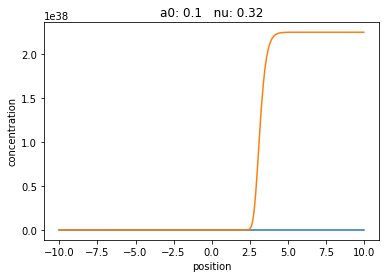

substrate is good


ValueError: cannot convert float NaN to integer

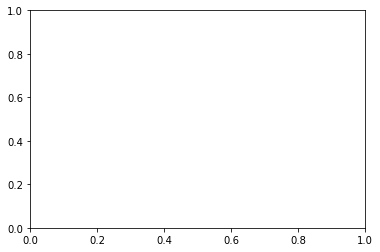

In [20]:
#check that substrate was long enough so that all Ac >= 1e-8 is used in integration

for i in range(a0_n):
    for j in range(nu_n):
        speed = v_a0[i][j] 
        testxs = xsf(speed,tc)
        testAc = a_c(speed,testxs,a0s[i],nus[j],tc)
        testAs = a0s[i] * exp((sqrt(pi/2)*spe.erf((testxs)/sqrt(2))-1)/speed) # want these values at t=0


        if testAc[0] < 1e-8 and testAc[-1] < 1e-8: # just check end points
            print("substrate good")
            display.clear_output(wait=True)
            plot(testxs,testAc) # just to have a look
            plot(testxs,testAs)
            title("a0: "+str(round(a0s[i],2)) + "   nu: "+str(round(nus[j],2)))
            ylabel("concentration")
            xlabel("position")
            display.display(gcf())
            cla()
            input("substrate is good")
        else: 
            input("substrate not long enough")
        

In [4]:
#Euler numerical method

tf = 400.0 # max time that the simulation will run 

# define domain and lattice
Lmax = 30.0 
Lmin = -10.0
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)


e_a0 = []
for a0 in a0s: #solve the equations for each parameter value
    print(". . .  a0:  ", a0)
    e_nu = []
    for nu in nus:
        print("nu: ", nu)
        

        # initialize As and Ac for each run through
        As = zeros(Nx)
        As[xs > 0.0] = a0*1.0
        Ac = zeros(Nx)
        xp = zeros(1)


        dt = 0.001
        t_max = int(tf/dt)
        v_t = []
        for t in range(t_max): # loop through for every time step
            # first determine total force on hub
            fi = -(xp -xs) * Ac
            total_f = trapz(fi, x=xs)
            #THEN update As and Ac
            binding = exp(-0.5 * (xp - xs) ** 2) * As
            burnt = nu * Ac
            Ac += (binding - burnt) * dt
            As += - binding * dt
            xp += total_f*dt # NOW move hub
            v_t.append(total_f) # store the velocities at each time step
            if xp >= 20.0:
                break
            
        e_nu.append([v_t,t])
    e_a0.append(e_nu)

. . .  a0:   0.1
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   0.1778279410038923
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   0.31622776601683794
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   0.5623413251903491
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   1.0
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   1.7782794100389228
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   3.1622776601683795
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   5.623413251903491
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   10.0
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   17.78279410038923
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   31.622776601683793
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   56.23413251903491
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0
. . .  a0:   100.0
nu:  0.1
nu:  0.32
nu:  1.0
nu:  3.16
nu:  10.0


In [ ]:
# a quick look at the velocity curves to convince myself that the numerical simulations reach a steady state
for i in range(nu_n):
    t_max = e_a0[0][i][1]+1
    tf = int(t_max*dt)
    plot(linspace(0,tf,t_max),e_a0[0][i][0], label = str(round(nus[i],2)))
#legend()
    

In [4]:
#BDF numerical method
# used the core of Eldon's example code

tf = 400.0 # max time that the simulation will run 


# define domain and lattice
Lmax = 30.0 
Lmin = -10.0
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xAs = linspace(Lmin, Lmax, Nx)

# define event as having gone to x = 20.0
def event(t, y):
    x0 = y[0]
        
    return 20.0-x0

event.direction = 0        
event.terminal = True     # stop solver if event satisfied


# returns vector of dx/dt, dAcx/dt and dAx/dt in that order

def derivs(t, y, nu, xAs):
    x0 = y[0]               # position of hub
    N = int(0.5*(len(y)-1))   # of lattice sites
    Acx = y[1:N+1]          # bound complex on lattice
    Ax = y[-N:]             # free complex on lattice
    
    dxcdt = trapz(-(x0-xAs)*Acx, x=xAs)  # force equation
    binding = exp(-0.5*(x0-xAs)**2)*Ax 
    burnt = nu*Acx

    dAcxdt = (binding - burnt)   # complex chemistry
    dAxdt = -binding            # free substrate chemistry
    
    return array( [dxcdt] + list(dAcxdt) + list(dAxdt))     # maybe a better way to put them all together


#I.C.

v_a0n = []  # record final speed
for a0 in a0s:
    
    A0x = zeros(Nx)
    A0x[xAs > 0.0] = a0
    # A0x = a0*ones(Nx) + 0.1*a0*2.0*(0.5-random.random(Nx))

    # iterate over params
    v_nu = []
    for nu in nus:
        print(a0, nu)

        x0 = 0.0
        Ax = 1.0*A0x
        Acx = zeros(Nx)

        # initial conditions for all the equations, y0
        y0 = array([x0] + list(Acx) + list(Ax))
        
        #Rk45 and other methods create in v(t) oscillations for nu << a0
        sol = sci.solve_ivp(lambda t, y: derivs(t, y, nu, xAs), (0.0, tf), y0, events=[event], method='BDF')
        
        #get the velocity curves
        v_t = []
        ts = []
        for t in range(len(sol.t)):
            v_t.append(derivs(sol.t[t], sol.y[:,t], nu, xAs)[0])
            ts.append(sol.t[t])
        
        
        v_nu.append([v_t,ts])
    v_a0n.append(v_nu)

0.1 0.1
0.1 0.11787686347935872
0.1 0.13894954943731375
0.1 0.16378937069540642
0.1 0.193069772888325
0.1 0.22758459260747882
0.1 0.2682695795279726
0.1 0.31622776601683794
0.1 0.372759372031494
0.1 0.43939705607607904
0.1 0.517947467923121
0.1 0.6105402296585328
0.1 0.7196856730011519
0.1 0.8483428982440719
0.1 1.0
0.1 1.1787686347935873
0.1 1.3894954943731375
0.1 1.6378937069540638
0.1 1.9306977288832496
0.1 2.2758459260747874
0.1 2.6826957952797246
0.1 3.1622776601683795
0.1 3.72759372031494
0.1 4.39397056076079
0.1 5.17947467923121
0.1 6.105402296585327
0.1 7.196856730011517
0.1 8.483428982440717
0.1 10.0
0.1 11.787686347935866
0.1 13.894954943731374
0.1 16.37893706954063
0.1 19.306977288832496
0.1 22.758459260747887
0.1 26.826957952797247
0.1 31.622776601683793
0.1 37.27593720314938
0.1 43.939705607607905
0.1 51.794746792312075
0.1 61.054022965853264
0.1 71.96856730011514
0.1 84.83428982440716
0.1 100.0
0.32 0.1
0.32 0.11787686347935872
0.32 0.13894954943731375
0.32 0.163789370695

In [ ]:
# a quick look at the velocity curves to convince myself that the numerical simulations reach a steady state
for i in range(a0_n):
    for j in range(nu_n):
        plot(v_a0n[i][j][1],v_a0n[i][j][0], label = str(round(nus[j],2)))
        #legend()
    show()
    
    

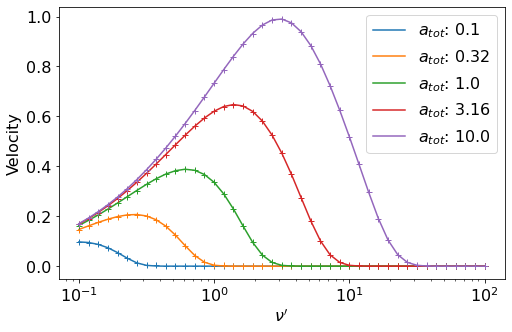

In [11]:
v_a0 = array(v_a0)
#probably not the best way to do this but I could not figure out how to work in array operations of the ragged arrays
v_final = zeros((a0_n,nu_n))
for i in range(a0_n):
    for j in range(nu_n):
        v_final[i][j] = v_a0n[i][j][0][-1]

for i in range(a0_n):
    for j in range(nu_n):
        if isnan(v_a0[i][j]):
            v_a0[i][j] = 0.0
            
colors1 = ["silver", "lightpink", "lightcoral", "peachpuff", "bisque", "lawngreen", "cyan", "skyblue", "blueviolet", "violet"]
colors2 = ["dimgrey", "crimson", "darkred", "peru", "darkorange","forestgreen", "darkturquoise", "deepskyblue", "indigo", "magenta"]
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:grey","tab:olive","tab:cyan", "tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"]

#compare the analytic and numeric steady state velocities for a given a0
figure(figsize =(8,5))
for i in range(a0_n):
    plot(nus, v_a0[i],"-", color = colors[i], label = r"$a_{tot}$: "+str(round(a0s[i],2)))
    plot(nus, v_final[i],"+", color = colors[i])
    #plot(nus, v_finale[0],".-", label = r"Numeric Euler $a_{tot}$: "+str(round(a0s[0],2)))

    xscale("log")
    ylabel("Velocity", fontsize = 16)
    xlabel(r"$\nu'$", fontsize = 16)
    yticks(fontsize = 16)
    xticks(fontsize = 16)
    legend(fontsize = 16)

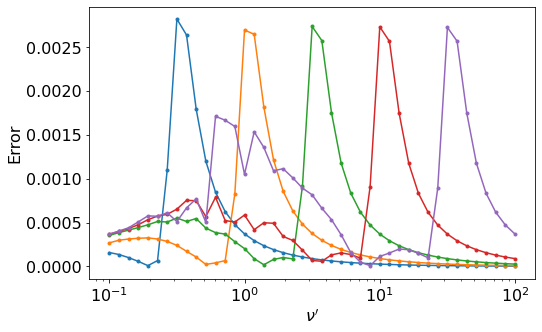

In [13]:
figure(figsize =(8,5))
for i in range(a0_n):
    actual = v_a0[i]
    diff = v_final[i]-actual
    '''for j in range(len(diff)):
        if diff[j] < 1e-2:
            diff[j] = 0.0'''
    plot(nus,abs(diff),".-", label = r"$a_{tot}$ = "   + str(round(a0s[i],2)))
    #plot(a0s,actual)
    xscale("log")
    #yscale("log")
    ylabel("Error",fontsize = 16)
    xlabel(r"$\nu'$",fontsize = 16)
    yticks(fontsize = 16)
    xticks(fontsize = 16)